In [31]:
import os, shutil
import numpy as np
import pandas as pd
from keras.datasets import mnist
from keras import models, layers, optimizers
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

from keras.utils import to_categorical, load_img, img_to_array, array_to_img
from sklearn.model_selection import train_test_split
from keras_preprocessing.sequence import pad_sequences
from keras import backend as K
import keras
from keras import Input
from keras.models import Model, Sequential

import matplotlib.pyplot as plt

import plotly.express as px
import plotly.graph_objects as go
from plotly.offline import init_notebook_mode
init_notebook_mode(connected = True)

## Best pracitces

#### Keras functional API

Multiple input model

In [3]:
text_vocabulary_size = 10000
question_vocabulary_size = 10000
answer_vocabulary_size = 500

text_input = Input(shape=(None,), 
                   dtype='int32', 
                   name='text')
embedded_text = layers.Embedding(
    text_vocabulary_size, 64)(text_input)
encoded_text = layers.LSTM(32)(embedded_text)

question_input = Input(shape=(None,),
                        dtype='int32',
                        name='question')
embedded_question = layers.Embedding(
    question_vocabulary_size, 32)(question_input)
encoded_question = layers.LSTM(16)(embedded_question)

concatenated = layers.concatenate([encoded_text, encoded_question],
                                  axis=-1)
answer = layers.Dense(answer_vocabulary_size,
                activation='softmax')(concatenated)

model = Model([text_input, question_input], answer)
model.compile(optimizer='rmsprop',
        loss='categorical_crossentropy',
        metrics=['acc'])

In [4]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None, None)]       0           []                               
                                                                                                  
 question (InputLayer)          [(None, None)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, None, 64)     640000      ['text[0][0]']                   
                                                                                                  
 embedding_1 (Embedding)        (None, None, 32)     320000      ['question[0][0]']               
                                                                                              

In [6]:
num_samples = 1000
max_length = 100
text = np.random.randint(1, text_vocabulary_size,
                        size=(num_samples, max_length))
question = np.random.randint(1, question_vocabulary_size,
                        size=(num_samples, max_length))
answers = np.random.randint(0, 1,
                        size=(num_samples, answer_vocabulary_size))

In [ ]:
model.fit([text, question], answers, epochs=10, batch_size=128)
model.fit({'text': text, 'question': question}, answers, epochs=10, batch_size=128)

Multiple output model

In [2]:
vocabulary_size = 50000
num_income_groups = 10
posts_input = Input(shape=(None,), dtype='int32', name='posts')
embedded_posts = layers.Embedding(256, vocabulary_size)(posts_input)
x = layers.Conv1D(128, 5, activation='relu')(embedded_posts)
x = layers.MaxPooling1D(5)(x)
x = layers.Conv1D(256, 5, activation='relu')(x)
x = layers.Conv1D(256, 5, activation='relu')(x)
x = layers.MaxPooling1D(5)(x)
x = layers.Conv1D(256, 5, activation='relu')(x)
x = layers.Conv1D(256, 5, activation='relu')(x)
x = layers.GlobalMaxPooling1D()(x)
x = layers.Dense(128, activation='relu')(x)
age_prediction = layers.Dense(1, name='age')(x)
income_prediction = layers.Dense(num_income_groups,
                                activation='softmax',
                                name='income')(x)
gender_prediction = layers.Dense(1, activation='sigmoid', name='gender')(x)
model = Model(posts_input,
                [age_prediction, income_prediction, gender_prediction])

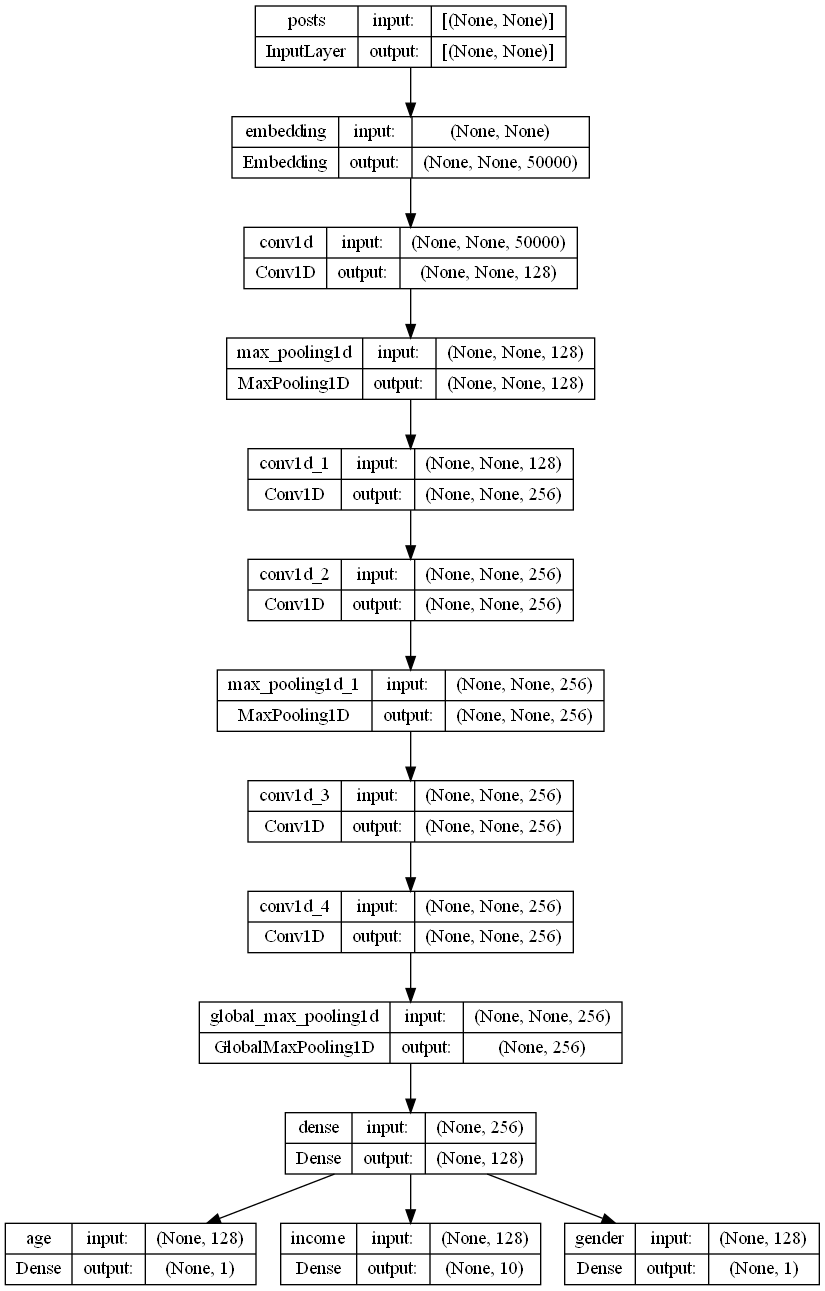

In [3]:
from keras.utils.vis_utils import plot_model
plot_model(model, show_shapes=True, show_layer_names=True)

In [4]:
model.compile(optimizer='rmsprop',
    loss=['mse', 
          'categorical_crossentropy', 
          'binary_crossentropy'],
    loss_weights=[0.25, 1., 10.])
model.compile(optimizer='rmsprop',
    loss={'age': 'mse',
        'income': 'categorical_crossentropy',
        'gender': 'binary_crossentropy'},
    loss_weights={'age': 0.25,
        'income': 1.,
        'gender': 10.})

In [ ]:
model.fit(posts, [age_targets, income_targets, gender_targets],
    epochs=10, batch_size=64)
model.fit(posts, {'age': age_targets,
                  'income': income_targets,
                  'gender': gender_targets},
          epochs=10, batch_size=64

Inception modules

In [16]:
x = Input(shape=(None, 128, 128))
branch_a = layers.Conv2D(128, 1,
                        activation='relu', strides=2)(x)
branch_b = layers.Conv2D(128, 1, activation='relu', padding='same')(x)
branch_b = layers.Conv2D(128, 3, activation='relu', strides=2, padding='same')(branch_b)
branch_c = layers.AveragePooling2D(3, strides=2, padding='same')(x)
branch_c = layers.Conv2D(128, 3, activation='relu', padding='same')(branch_c)
branch_d = layers.Conv2D(128, 1, activation='relu', padding='same')(x)
branch_d = layers.Conv2D(128, 3, activation='relu', padding='same')(branch_d)
branch_d = layers.Conv2D(128, 3, activation='relu', strides=2, padding='same')(branch_d)
output = layers.concatenate(
    [branch_a, branch_b, branch_c, branch_d], axis=-1)
model = Model([branch_a, branch_b, branch_c, branch_d],
              output)

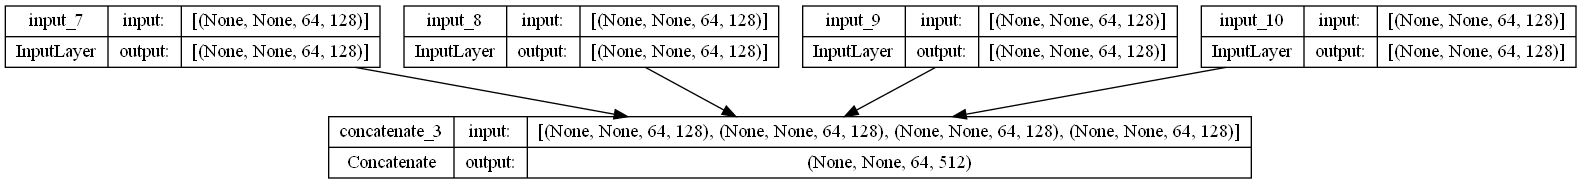

In [17]:
plot_model(model, show_shapes=True, show_layer_names=True)

Residual connections

In [12]:
x = Input(shape=(None, 128, 128))
y = layers.Conv2D(128, 3, activation='relu', padding='same')(x)
y = layers.Conv2D(128, 3, activation='relu', padding='same')(y)
y = layers.Conv2D(128, 3, activation='relu', padding='same')(y)
y = layers.add([y, x])

model = Model(x,y)

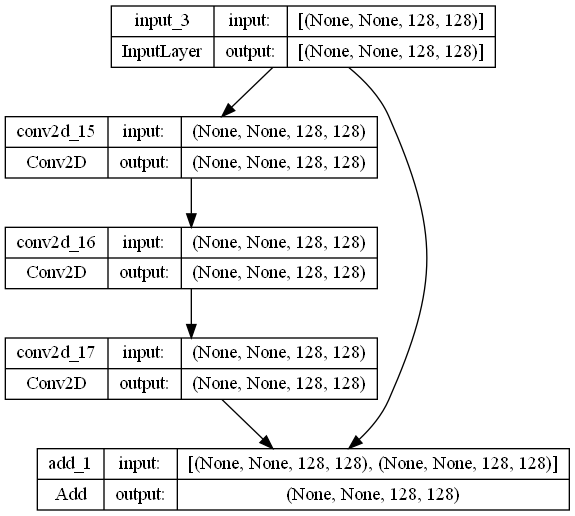

In [13]:
plot_model(model, show_shapes=True, show_layer_names=True)

Layer weight sharing (Siamese LSTM model or a shared LSTM)

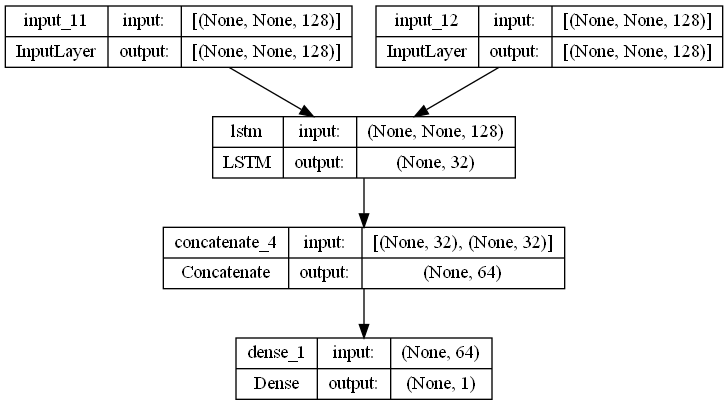

In [18]:
lstm = layers.LSTM(32)
left_input = Input(shape=(None, 128))
left_output = lstm(left_input)
right_input = Input(shape=(None, 128))
right_output = lstm(right_input)
merged = layers.concatenate([left_output, right_output], axis=-1)
predictions = layers.Dense(1, activation='sigmoid')(merged)
model = Model([left_input, right_input], predictions)
plot_model(model, show_shapes=True, show_layer_names=True)

Models as layers: Siamese vision model (shared convolutional base)

In [23]:
from keras import applications
xception_base = applications.Xception(weights=None,
            include_top=False)

left_input = Input(shape=(250, 250, 3))
right_input = Input(shape=(250, 250, 3))
left_features = xception_base(left_input)
right_features = xception_base(right_input)
merged_features = layers.concatenate(
    [left_features, right_features], axis=-1)
model = Model([left_input, right_input], merged_features)

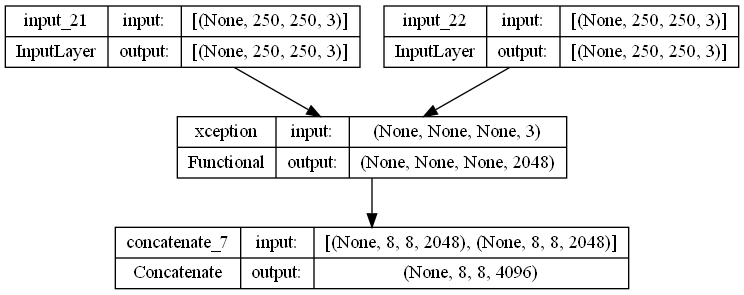

In [24]:
plot_model(model, show_shapes=True, show_layer_names=True)

#### Using callbacks to act on a model during training

The ModelCheckpoint and EarlyStopping callbacks

In [ ]:
import keras
callbacks_list = [
    keras.callbacks.EarlyStopping(
        monitor='acc',
        patience=1),
    keras.callbacks.ModelCheckpoint(
        filepath='my_model.h5',
        monitor='val_loss',
        save_best_only=True)]
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
model.fit(x,y,
          epochs=10,
          callbacks=callbacks_list,
          validation_data=(x_val, y_val))

The ReduceLROnPlateu callback

In [ ]:
callbacks_list = [
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.1,
        patience=10)]
model.fit(x, y,
    epochs=10,
    batch_size=32,
    callbacks=callbacks_list,
    validation_data=(x_val, y_val))

Custom callbacks

In [ ]:
class ActivationLogger(keras.callbacks.Callback):
    def set_model(self, model):
        self.model = model
        layer_output = [layer.output for layer in model.outputs]
        self.activations_model = Model(model.input, layer_output)
        
    def on_epoch_end(self, epoch, logs=None):
        if self.validation_data is None:
            raise RuntimeError('Requires validation_data.')
        validation_sample = self.validation_data[0][0:1]
        activations = self.activations_model.predict(validation_sample)
        with open('activations_at_epoch_' + str(epoch) + '.npz', 'w') as f:
            np.savez(f, activations)

#### TensorBoard

In [28]:
from keras.datasets import imdb
max_features = 2000
max_len = 500
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)
x_train = pad_sequences(x_train, maxlen=max_len)
x_test = pad_sequences(x_test, maxlen=max_len)
model = Sequential()
model.add(layers.Embedding(max_features, 128,
            input_length=max_len,
            name='embed'))
model.add(layers.Conv1D(32, 7, activation='relu'))
model.add(layers.MaxPooling1D(5))
model.add(layers.Conv1D(32, 7, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(1))
model.summary()
model.compile(optimizer='rmsprop',
            loss='binary_crossentropy',
            metrics=['acc'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embed (Embedding)           (None, 500, 128)          256000    
                                                                 
 conv1d_5 (Conv1D)           (None, 494, 32)           28704     
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 98, 32)           0         
 1D)                                                             
                                                                 
 conv1d_6 (Conv1D)           (None, 92, 32)            7200      
                                                                 
 global_max_pooling1d_1 (Glo  (None, 32)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_2 (Dense)             (None, 1)                 3

In [34]:
callbacks = [
    keras.callbacks.TensorBoard(
        log_dir='my_log_dir',
        histogram_freq=1,
        embeddings_freq=1
    )
]
history = model.fit(x_train, y_train,
                    epochs=20,
                    batch_size=128,
                    validation_split=0.2,
                    callbacks=callbacks)

Epoch 1/20
157/157 [==============================] - 25s 150ms/step - loss: 0.6314 - acc: 0.6748 - val_loss: 0.5300 - val_acc: 0.7806
Epoch 2/20
157/157 [==============================] - 26s 168ms/step - loss: 0.4498 - acc: 0.8496 - val_loss: 0.4229 - val_acc: 0.8634
Epoch 3/20
157/157 [==============================] - 28s 175ms/step - loss: 0.4005 - acc: 0.8776 - val_loss: 0.4529 - val_acc: 0.8646
Epoch 4/20
157/157 [==============================] - 25s 159ms/step - loss: 0.3457 - acc: 0.8972 - val_loss: 0.5322 - val_acc: 0.8572
Epoch 5/20
157/157 [==============================] - 23s 144ms/step - loss: 0.3062 - acc: 0.9173 - val_loss: 0.6225 - val_acc: 0.8644
Epoch 6/20
157/157 [==============================] - 24s 154ms/step - loss: 0.2696 - acc: 0.9335 - val_loss: 0.6393 - val_acc: 0.8688
Epoch 7/20
157/157 [==============================] - 26s 164ms/step - loss: 0.2280 - acc: 0.9555 - val_loss: 0.8535 - val_acc: 0.8430
Epoch 8/20
157/157 [==============================] - 2